In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2 #pip install opencv-python

IMG = './dataset'
img_dataset = []
genre_target = []
genres = {}
i = 0
for root, dirs, files in os.walk(IMG):
    for name in files:
        filename = os.path.join(root, name)
        img_dataset.append(filename)
        genre_target.append(filename.split("\\")[-2])
        genre = filename.split('\\')[-2]
        if(genre not in genres):
            genres[genre] = i
            i+=1

(217, 335)


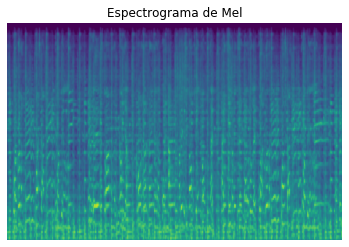

In [9]:
import matplotlib.image as mpimg

img = cv2.imread(img_dataset[0],0)
print(img.shape)
plt.imshow(img, interpolation = 'bicubic', cmap='viridis')
plt.title("Espectrograma de Mel")
plt.axis('off')
plt.show()

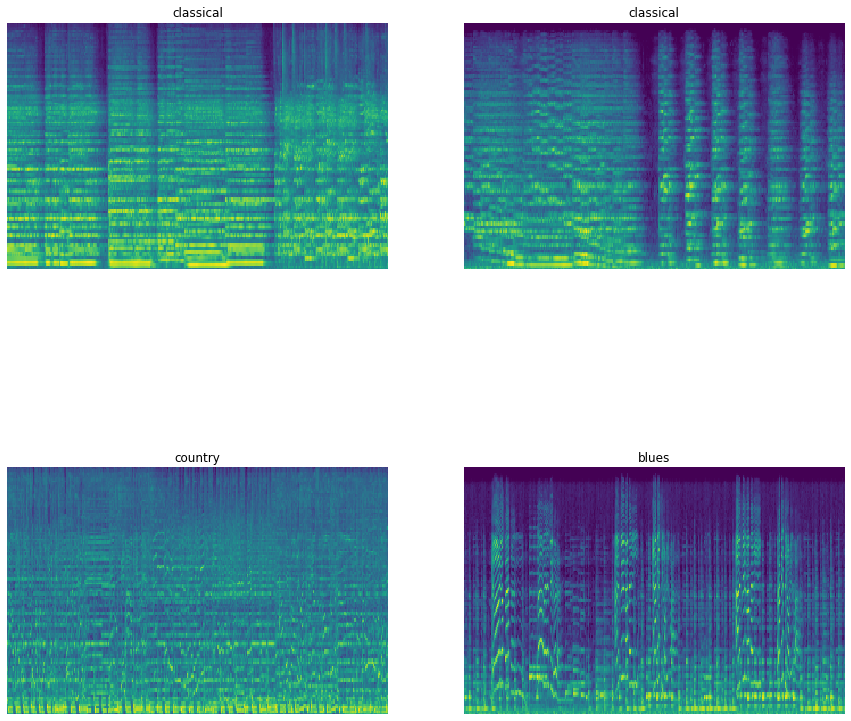

In [12]:
fig=plt.figure(figsize=(15, 15))
columns = 2
rows = 2
sample = np.random.choice(len(img_dataset), columns*rows)
for i, j in zip(range(1, columns*rows +1),sample):
    img = cv2.imread(img_dataset[j],0)
    fig.add_subplot(rows, columns, i)
    plt.title(genre_target[j])
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [13]:
def get_y():
    y = []
    for genre in genre_target:
        n = genres[genre]
        y.append(n)
    return np.array(y)
def get_x(shape=[999,217,335], flag=0):
    x = np.empty(shape, np.uint8)
    for i in range(len(img_dataset)):
        img = cv2.imread(img_dataset[i],flag)
        x[i] = img
    return x

In [17]:
x = get_x([len(img_dataset),217,335,3], flag=1) #RGB
X = get_x([len(img_dataset),217,335]) #Greyscale

In [18]:
print(X.shape, x.shape)

(244, 217, 335) (244, 217, 335, 3)


In [19]:
def show_sample_imgs(dataset, cmap='gray', c=5, r=2):
    np.random.seed(5)
    fig=plt.figure(figsize=(15, 15))
    columns = c
    rows = r
    sample = np.random.choice(len(img_dataset), columns*rows, 42)
    for i, j in zip(range(1, columns*rows +1),sample):
        fig.add_subplot(rows, columns, i)
        plt.title(genre_target[j])
        plt.imshow(dataset[j], cmap)
        plt.axis('off')
    plt.show()

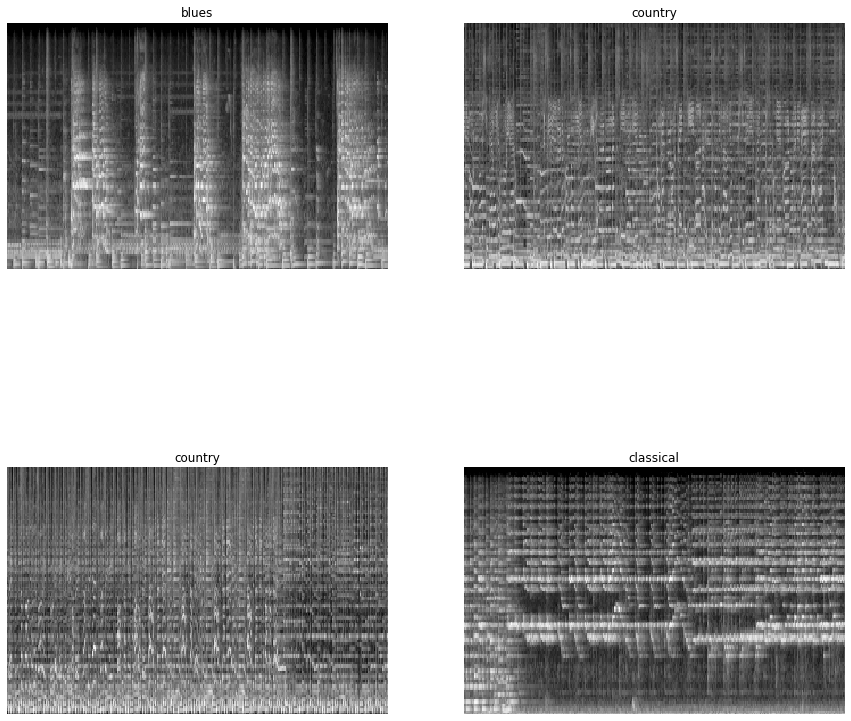

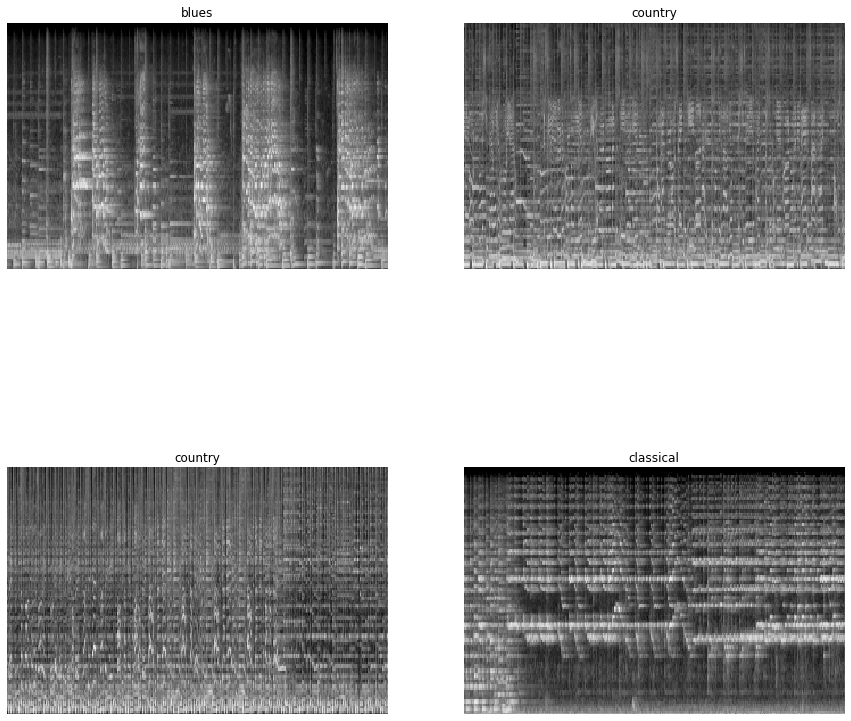

In [20]:
show_sample_imgs(X, c=2, r=2)
show_sample_imgs(x, c=2, r=2)